# ViT Small Pretrained on DINOv2 with registers 

## Augmentation: TrivialAugmentWide to 60000 samples

## Data: Corallo vs Myxo

### import requirements

In [1]:
import copy
import torchvision.models as models
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms, autoaugment
from sklearn.utils import resample
import os
import numpy as np
import matplotlib.pyplot as plt

## Preparing Data

### Loading Original Dataset

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}')

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.255])

batch_size = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomResizedCrop((224, 224)),
        transforms.Normalize(mean, std)
    ])
}

data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo'
datasets = {x: ImageFolder(root=os.path.join(data_path, x), transform=data_transforms[x]) for x in ['train', 'val']}
print('datasets have been created')

dataloaders = {x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=2, shuffle=False, drop_last=True)
               for x in ['train', 'val']}
print('dataloaders have been created')

class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')

class_counts = {x: len(datasets[x]) for x in ['train', 'val']}
print(f'Dataset sizes: {class_counts}')

your device is cuda
datasets have been created
dataloaders have been created
there are 2 classes, and class names are ['Corallococcus', 'Myxococcus']
Dataset sizes: {'train': 415, 'val': 100}


### Counting Classes 

In [3]:
from collections import Counter

class_counts = Counter()

for phase in ['train', 'val']:
    for _, label in dataloaders[phase]:
        class_counts.update(label.tolist())

# show details
for label, count in class_counts.items():
    print(f'Class {label}: {count} instances')

Class 0: 324 instances
Class 1: 156 instances


### Defining Augmentation Class 

In [4]:
class CustomAugmentedDataset(Dataset):
    def __init__(self, root_dir, num_samples_per_class, transform=None, num_magnitude_bins=30):
        """
        Args:
            root_dir (string): Directory with all the images.
            num_samples_per_class (int): Desired number of samples per class after augmentation.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataset = ImageFolder(root=root_dir)
        self.classes = self.dataset.classes
        self.num_samples_per_class = num_samples_per_class
        self.transform = transform
        self.augment_transform = transforms.Compose([
            autoaugment.TrivialAugmentWide(num_magnitude_bins=num_magnitude_bins),
            transforms.ToTensor(),
            transforms.Resize((224, 224))
        ])
        self.class_samples = self._balance_classes()

    def _balance_classes(self):
        from collections import defaultdict
        class_indices = defaultdict(list)
        
        for idx, (_, class_id) in enumerate(self.dataset.samples):
            class_indices[class_id].append(idx)
        
        # Reduce or oversample class indices to match num_samples_per_class
        balanced_indices = []
        for indices in class_indices.values():
            if len(indices) >= self.num_samples_per_class:
                balanced_indices.extend(indices[:self.num_samples_per_class])
            else:
                # Oversample if there are fewer samples than desired
                oversampled_indices = indices * (self.num_samples_per_class // len(indices)) + indices[:self.num_samples_per_class % len(indices)]
                balanced_indices.extend(oversampled_indices)
                
        return balanced_indices

    def __len__(self):
        return len(self.class_samples)

    def __getitem__(self, idx):
        img, label = self.dataset[self.class_samples[idx]]
        if self.transform is not None:
            img = self.transform(img)
        else:
            img = self.augment_transform(img)
        return img, label
    
    def classes(self):
        return self.classes

### Creating Augmented Dataset

In [5]:
# Define Parameters
data_path = 'D:\Master Project\model\model-1\Corallo-vs-Myxo'
num_magnitude_bins = 100
num_samples_per_class = 50000

# Define any additional transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Flipping the image horizontally
    transforms.RandomRotation(degrees=20),  # Rotate by -20 to +20 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  # Translation
    transforms.ColorJitter(brightness=0.2),  # Adjusting Brightness
    transforms.ColorJitter(contrast=0.2),
    transforms.ToTensor(), 
    transforms.Resize((224, 224))# Adjusting Contrast
])


# Creating datasets
datasets = {
    x: CustomAugmentedDataset(root_dir=os.path.join(data_path, x), num_magnitude_bins=num_magnitude_bins, transform=aug_transform, num_samples_per_class=num_samples_per_class if x == 'train' else 3000) 
    for x in ['train', 'val']
}
print('Datasets created.')

# Creating dataloaders
batch_size = 32
dataloaders = {
    x: DataLoader(dataset=datasets[x], batch_size=batch_size, num_workers=0, shuffle=True if x == 'train' else False, drop_last=True)
    for x in ['train', 'val']
}
print('Dataloaders created.')
print('-' * 50)

# Show Classes
class_names = datasets['train'].classes
print(f'there are {len(class_names)} classes, and class names are {class_names}')
print('-' * 50)

# Show datasets length 
print('train dataset: ', len(datasets['train']))
print('val dataset: ', len(datasets['val']))

Datasets created.
Dataloaders created.
--------------------------------------------------
there are 2 classes, and class names are ['Corallococcus', 'Myxococcus']
--------------------------------------------------
train dataset:  100000
val dataset:  6000


### Counting Classes

In [6]:
# from collections import Counter
# 
# class_counts = Counter()
# 
# for phase in ['train', 'val']:
#     for _, label in dataloaders[phase]:
#         class_counts.update(label.tolist())
# 
# # show details
# for label, count in class_counts.items():
#     print(f'Class {label}: {count} instances')

# Showing augmented data sample 

idx:  46821
idx type:  <class 'numpy.ndarray'>
image type:  <class 'torch.Tensor'>
label:  0
class name label:  Corallococcus


C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_9268\3996132560.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print('idx: ', int(idx))
C:\Users\Mahdiar\AppData\Local\Temp\ipykernel_9268\3996132560.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  image, label = datasets['train'][int(idx)]
C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To 

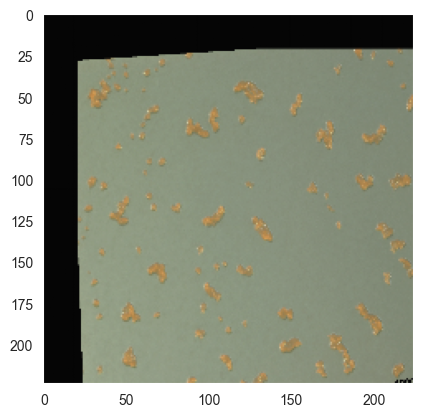

In [7]:
import matplotlib.pyplot as plt
idx = np.random.randint(0, 60000, size=1)

print('idx: ', int(idx))
print('idx type: ', type(idx))
image, label = datasets['train'][int(idx)]    
print('image type: ', type(image))
print('label: ', label)
print('class name label: ', class_names[label])

# Convert torch tensor for plotting
image = image.permute(1,2,0)
plt.imshow(image)
plt.grid(False)
plt.show()


# Load ViT pretrained on DINOv2 with registers model

In [8]:
# DINOv2
dinov2_vits14_21M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
dinov2_vitb14_86M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
# dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

# DINOv2 with registers
dinov2_vits14_reg_21M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
dinov2_vitb14_reg_86M = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14_reg')
# dinov2_vitl14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14_reg')
# dinov2_vitg14_reg = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14_reg')

Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main\dinov2\layers\block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main
Using cache found in C:\Users\Mahdiar/.cache\torch\hub\facebookresearch_dinov2_main


# Fine-Tune model classifier and trainable parameters 

In [9]:
# Define model
model = dinov2_vits14_reg_21M

# Define classifier for Binary Classification task
model.head  = nn.Sequential(
    nn.Linear(384, 2)
)
print(dinov2_vits14_reg_21M)

# Set about 30% of parameters trainable 
model_params = 0
for idx, param in enumerate(model.parameters()):
    param.requires_grad = False
    model_params += 1
    if idx == 130:
        break

DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-11): 12 x NestedTensorBlock(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (n

## Defining Train function 

In [10]:
from datetime import datetime
from easydict import EasyDict


# train function 
def train_model(model, criterion, optimizer, dataloaders, datasets, epoch_num=25):
    acc_list = EasyDict({'train': [], 'val': []})
    loss_list = EasyDict({'train': [], 'val': []})

    # Copy the best model weights for loading at the End
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0.0

    # Iterating over epochs
    for epoch in range(1, epoch_num + 1):
        print(f'Epoch {epoch}/{epoch_num}:')

        # Each epoch has two phase Train and Validation
        for phase in ['train', 'val']:
            s0 = datetime.now()
            if phase == 'train':
                model.train()
            else:
                model.eval()

            # For calculating Loss and Accuracy at the end of epoch
            running_loss = 0.0
            running_corrects = 0.0

            # Iterating over batches and data for training and validation
            for idx, batch in enumerate(dataloaders[phase], 0):
                inputs, labels = batch

                # Transfer data and labels to CUDA if is available
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                # Forward Pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, predictions = torch.max(outputs, 1)

                    # Back Propagation and updating weights
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == labels.data)

            # Calculating Accuracy and Loss per phase
            epoch_loss = running_loss / len(datasets[phase])
            epoch_accuracy = running_corrects / len(datasets[phase])

            # Show epoch details
            delta = datetime.now() - s0
            print(f'{phase.capitalize()} Accuracy: {epoch_accuracy:.4f} | Loss: {epoch_loss:.4f} | time: {delta}')

            # Copy the model weights if its better
            if phase == 'val' and epoch_accuracy > best_accuracy:
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
                print('Best model weights updated!')

            # Save Loss and accuracy
            acc_list[phase].append(epoch_accuracy)
            loss_list[phase].append(epoch_loss)
        print('-' * 50)

    print(f'Best Accuracy: {best_accuracy:.4f}')

    # Loading best model weights 
    model.load_state_dict(best_model_wts)
    return model, acc_list, loss_list

# Train ViT-s DINOv2 with registers 
---------------
## Hyperparameters:
### optimizer: Adam
### criterion: CrossEntropy
### Learning Rate: 0.001
### batch size: 32
### epoch: 50

In [11]:
# Defining hyperparameters
criterion = CrossEntropyLoss()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'your device is {device}', end='\n\n')
optimizer = Adam(model.parameters(), lr=0.0003)
model = model.to(device)
# print(model)
print('-' * 50)
print('Training starts at: ', datetime.now(), end='\n\n')
# train model
model, acc_lists, loss_lists = train_model(model, criterion, optimizer, dataloaders, datasets, epoch_num=10)
print()
print('Training ends at: ', datetime.now())


your device is cuda

--------------------------------------------------
Training starts at:  2024-04-27 23:59:15.387070

Epoch 1/10:
Train Accuracy: 0.9818 | Loss: 0.0476 | time: 0:58:36.854891
Val Accuracy: 0.7528 | Loss: 1.0591 | time: 0:03:25.929833
Best model weights updated!
--------------------------------------------------
Epoch 2/10:
Train Accuracy: 0.9972 | Loss: 0.0092 | time: 0:58:35.654926
Val Accuracy: 0.8273 | Loss: 1.2948 | time: 0:03:25.805444
Best model weights updated!
--------------------------------------------------
Epoch 3/10:
Train Accuracy: 0.9961 | Loss: 0.0129 | time: 0:58:41.431431
Val Accuracy: 0.8067 | Loss: 0.8941 | time: 0:03:26.154398
--------------------------------------------------
Epoch 4/10:
Train Accuracy: 0.9981 | Loss: 0.0069 | time: 0:58:39.204182
Val Accuracy: 0.8387 | Loss: 1.0259 | time: 0:03:25.472988
Best model weights updated!
--------------------------------------------------
Epoch 5/10:
Train Accuracy: 0.9981 | Loss: 0.0064 | time: 0:58:

## Plot Results 

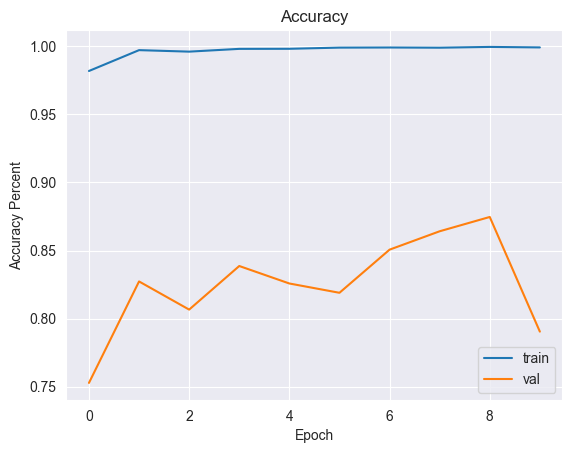

In [12]:
plt.plot([a.cpu() for a in acc_lists.train], label='train')
plt.plot([a.cpu() for a in acc_lists.val], label='val')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

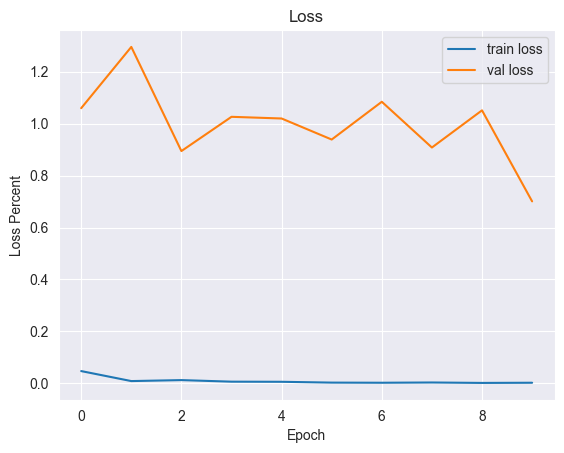

In [13]:
plt.plot([a for a in loss_lists.train], label='train loss')
plt.plot([a for a in loss_lists.val], label='val loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Percent')
plt.legend()
plt.show()


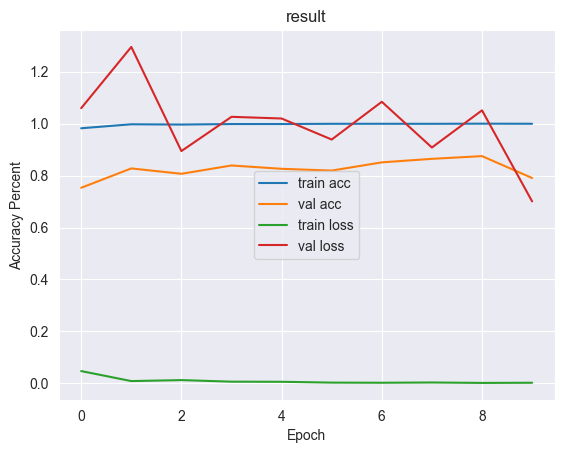

In [14]:
plt.plot([a.cpu() for a in acc_lists.train], label='train acc')
plt.plot([a.cpu() for a in acc_lists.val], label='val acc')
plt.plot([a for a in loss_lists.train], label='train loss')
plt.plot([a for a in loss_lists.val], label='val loss')
plt.title('result')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Percent')
plt.legend()
plt.show()

## Save best model weights

In [15]:
torch.save(model, '../models/model_2_3.pth')

## Visualize model predictions

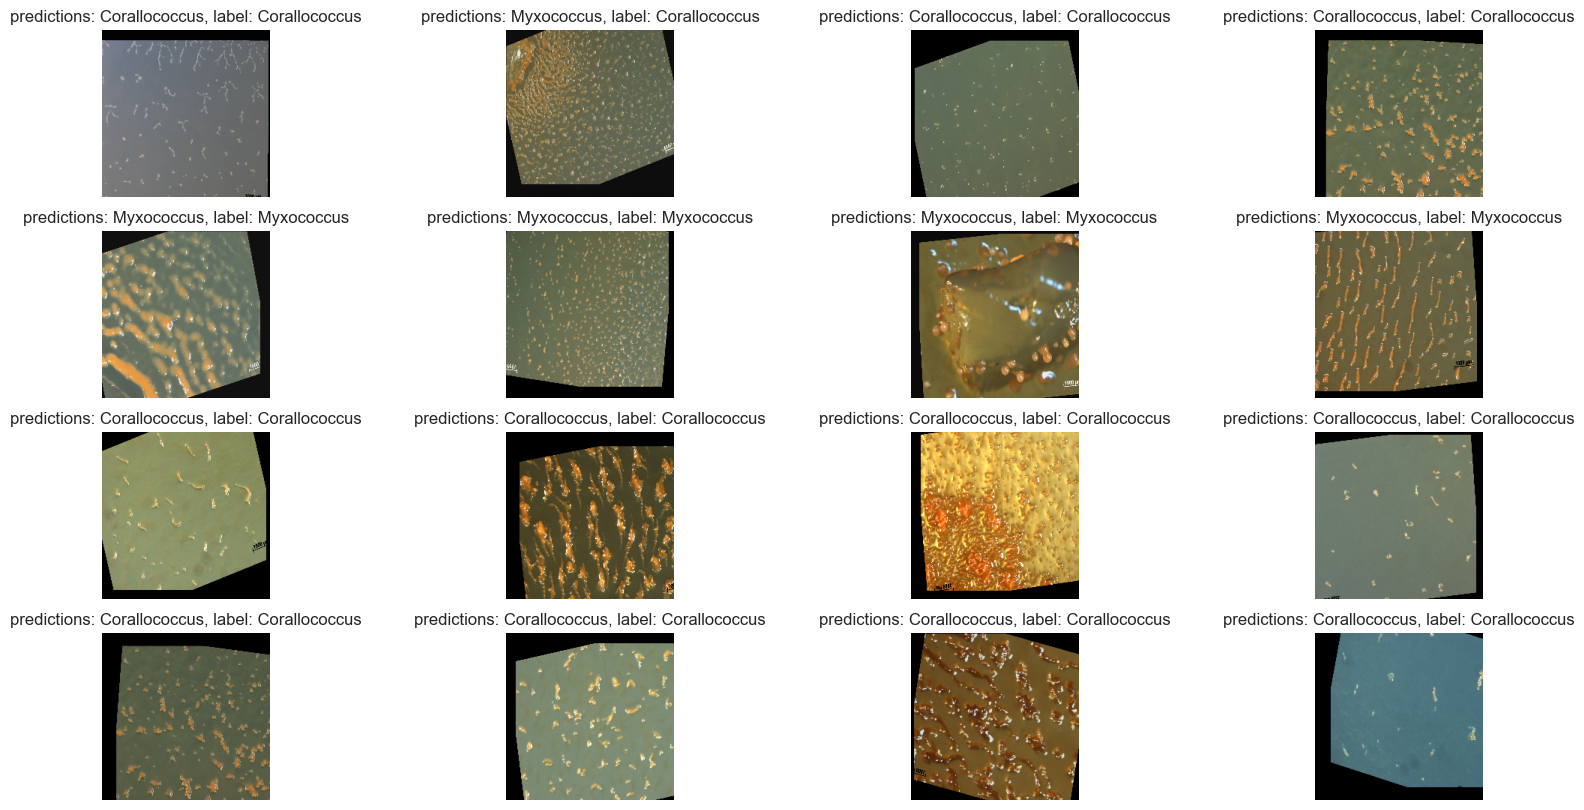

In [16]:
import itertools

def visualize_model(model):
    model.eval()
    nrows, ncols = 4, 4
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 10))
    
    # Determine how many batches are in the dataloader
    num_batches = len(dataloaders['val'])
    # Generate random batch indices
    random_batches = np.random.choice(range(num_batches), size=nrows, replace=False)

    with torch.no_grad():
        for i, batch_idx in enumerate(random_batches):
            # Retrieve the batch by the random index
            inputs, labels = next(itertools.islice(dataloaders['val'], batch_idx, None))

            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predictions = torch.max(outputs, 1)
            
            for j in range(ncols):
                if j >= inputs.size()[0]:  # Check if the batch is smaller than ncols
                    break

                img = inputs.cpu().data[j]
                img = img.numpy().transpose((1, 2, 0))
                img = np.clip(img, 0, 1)  # Normalize the image for display
                axes[i][j].axis('off')
                axes[i][j].set_title(
                    f'predictions: {class_names[predictions[j]]}, label: {class_names[labels[j]]}'
                )
                axes[i][j].imshow(img)
            
    plt.show()

# model = torch.load('../models/model_2.pth')
visualize_model(model)

C:\Users\Mahdiar\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


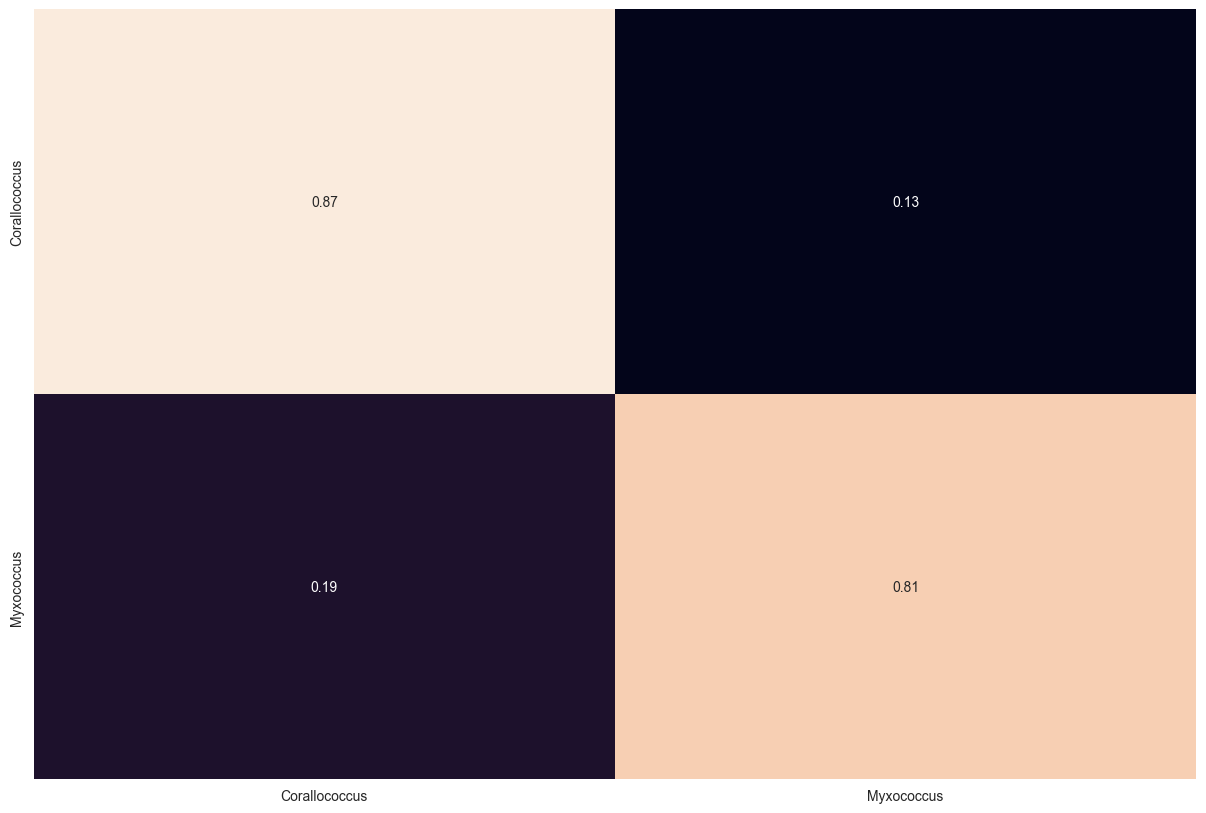

In [19]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

def plot_cm(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloaders['val']:
            inputs = inputs.to(device)
            outputs = model(inputs)

            outputs = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
            y_pred.extend(outputs)

            labels = labels.data.cpu().numpy()
            y_true.extend(labels)

    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(
        cm / np.sum(cm, axis=1)[:, None],
        index=[i for i in class_names],
        columns=[i for i in class_names]
    )

    plt.figure(figsize=(15, 10))
    sns.heatmap(df_cm, annot=True, cbar=False)
    plt.show()

plot_cm(model)